In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Feature Selection

We selected a subset of features that we believe represent an incident in its entirety

In [2]:
df = pd.read_csv("../data/new_incidents.csv", low_memory=False)
df_cut = df.copy()
df_cut = df_cut[['n_participants', 'n_involved', 'age_to_average', 'par_to_tot']]
df_cut.head()

,n_participants,n_involved,age_to_average,par_to_tot
0,1,1,0.647020,0.009091
1,1,1,2.126725,0.003861
2,2,1,0.908953,0.010638
3,2,1,0.963389,0.046512
4,1,1,2.215276,0.004587


In [3]:
df_cut.describe()

,n_participants,n_involved,age_to_average,par_to_tot
count,183654.000000,183654.000000,183654.000000,183654.000000
mean,1.810464,0.841261,1.000000,0.014124
std,1.133149,0.801174,0.370278,0.026565
min,1.000000,0.000000,0.000000,0.001143
25%,1.000000,0.000000,0.782518,0.003968
50%,2.000000,1.000000,0.927244,0.007246
75%,2.000000,1.000000,1.106918,0.014493
max,35.000000,27.000000,3.493709,1.000000


# Normalization

We use a MinMax scaler since it is known to perform well on this type of clustering

In [4]:
def normalization(df):
    scaler = MinMaxScaler()
    norm = scaler.fit_transform(df.values)
    df_norm = pd.DataFrame(norm, columns=df.columns)
    return df_norm

df_norm = df_cut.copy()
df_norm = normalization(df_norm)
df_norm.head()

,n_participants,n_involved,age_to_average,par_to_tot
0,0.000000,0.037037,0.185196,0.007957
1,0.000000,0.037037,0.608730,0.002721
2,0.029412,0.037037,0.260168,0.009506
3,0.029412,0.037037,0.275750,0.045421
4,0.000000,0.037037,0.634076,0.003448


# Calculating K

We calculate the best K to use in the clustering

Calculated k-means with k equal to 2
Calculated k-means with k equal to 3
Calculated k-means with k equal to 4
Calculated k-means with k equal to 5
Calculated k-means with k equal to 6
Calculated k-means with k equal to 7
Calculated k-means with k equal to 8
Calculated k-means with k equal to 9
Calculated k-means with k equal to 10
Calculated k-means with k equal to 11
Calculated k-means with k equal to 12
Calculated k-means with k equal to 13
Calculated k-means with k equal to 14
Calculated k-means with k equal to 15


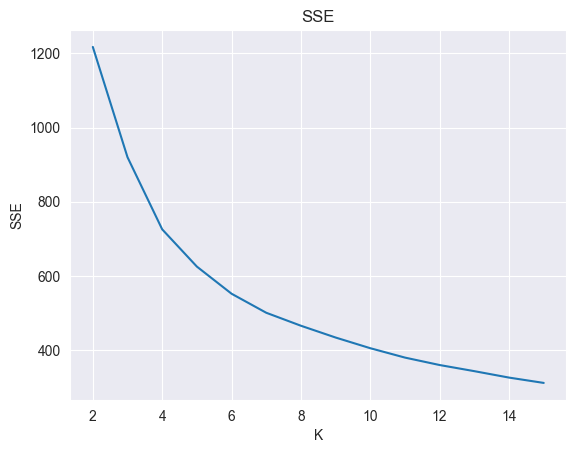

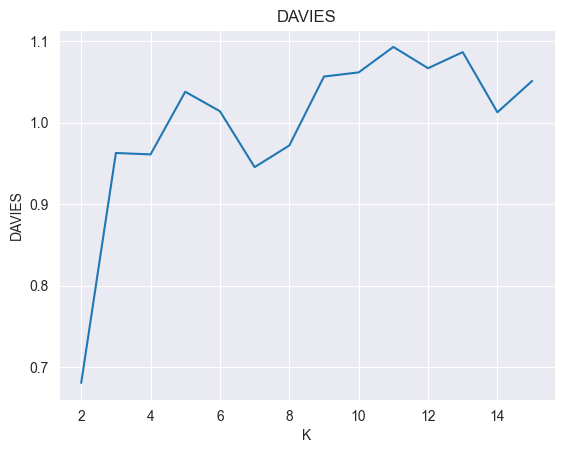

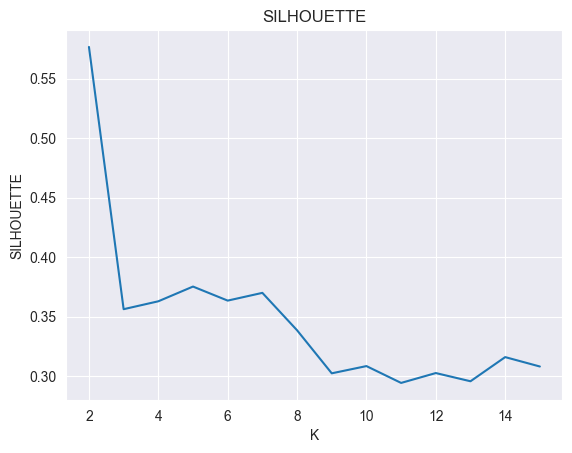

In [16]:
def k_means_calculation(df):
    sse = list()
    davies = list()
    silhouette = list()
    max_k = 15
    for k in range(2, max_k + 1):
        kmeans_pass = KMeans(n_clusters=k, n_init=10, max_iter=100)
        kmeans_pass.fit(df)
        sse_pass = kmeans_pass.inertia_
        sse.append(sse_pass)
        davies.append(davies_bouldin_score(df, kmeans_pass.labels_))
        silhouette.append(silhouette_score(df, kmeans_pass.labels_))
        print("Calculated k-means with k equal to " + str(k))
    plt.plot(range(2, len(sse) + 2), sse)
    plt.ylabel('SSE')
    plt.xlabel('K')
    plt.title('SSE')
    plt.show()
    plt.plot(range(2, len(davies) + 2), davies)
    plt.ylabel('DAVIES')
    plt.xlabel('K')
    plt.title('DAVIES')
    plt.show()
    plt.plot(range(2, len(silhouette) + 2), silhouette)
    plt.ylabel('SILHOUETTE')
    plt.xlabel('K')
    plt.title('SILHOUETTE')
    plt.show()

k_means_calculation(df_norm)

In [5]:
kmeans = KMeans(n_clusters = 7, n_init=100, random_state=42)
kmeans.fit(df_norm)
n_clusters = len(np.unique(kmeans.labels_))
occ_list = []
for k in range(n_clusters):
    occ_list.append(np.count_nonzero(kmeans.labels_ == k))
print('cluster occurrences:', occ_list)

cluster occurrences: [79730, 15189, 14441, 39970, 5573, 1325, 27426]


# Cluster occurrences

In [6]:
df_cut['Cluster'] = kmeans.labels_
df_cut.head()

,n_participants,n_involved,age_to_average,par_to_tot,Cluster
0,1,1,0.647020,0.009091,3
1,1,1,2.126725,0.003861,4
2,2,1,0.908953,0.010638,0
3,2,1,0.963389,0.046512,0
4,1,1,2.215276,0.004587,4


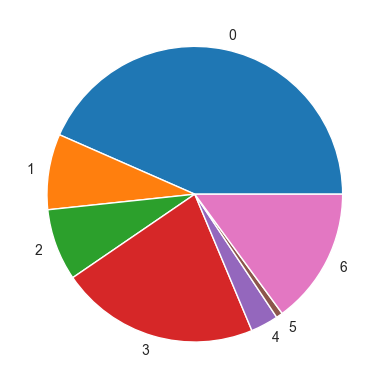

In [7]:
label = range(n_clusters)
plt.pie(occ_list, labels=label, colors=sn.color_palette(n_colors=n_clusters))
plt.show()

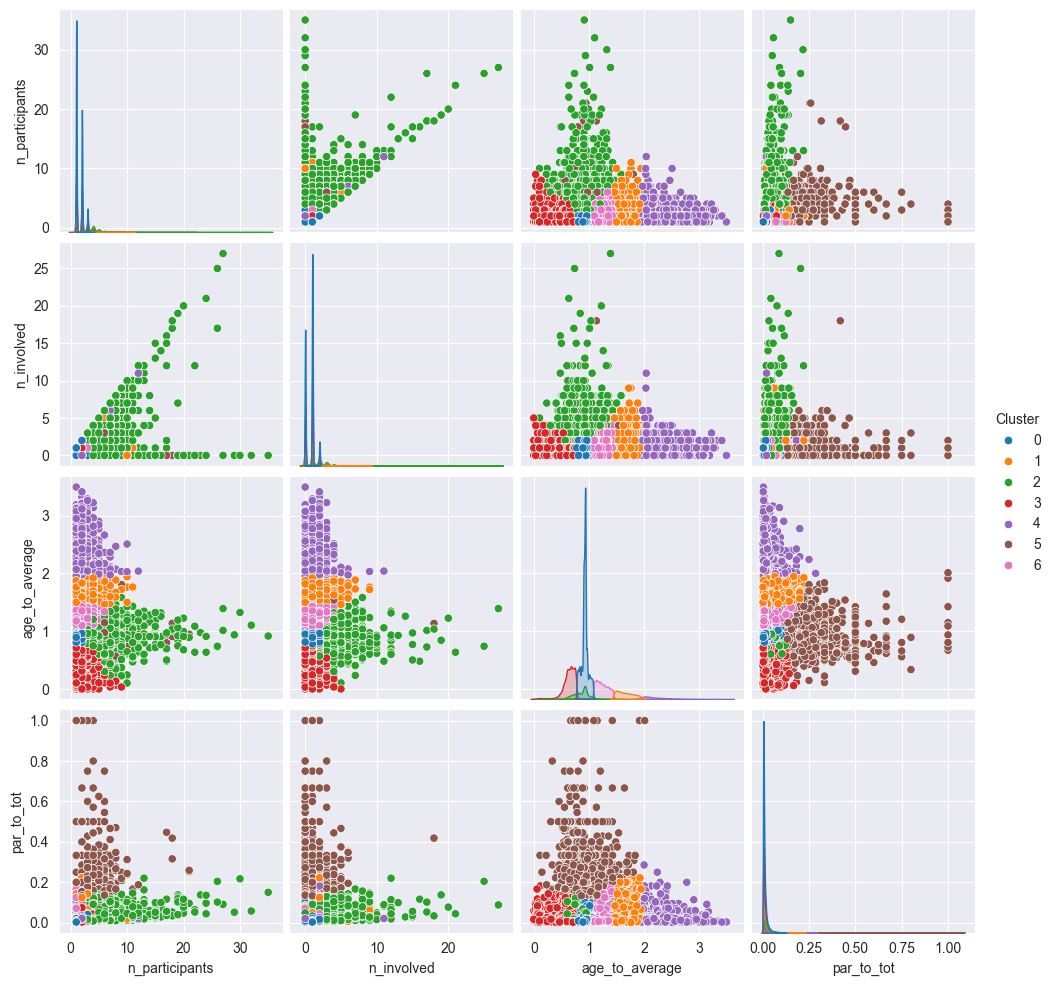

In [8]:
sn.pairplot(df_cut,hue='Cluster', palette=sn.color_palette(n_colors=n_clusters))
plt.show()

# Cluster analysis

Making graphs to understand the main differences between each cluster

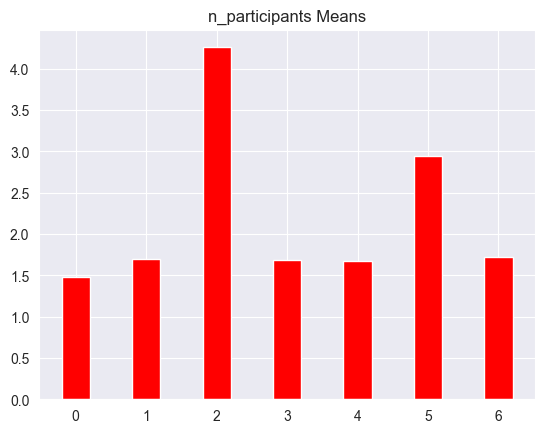

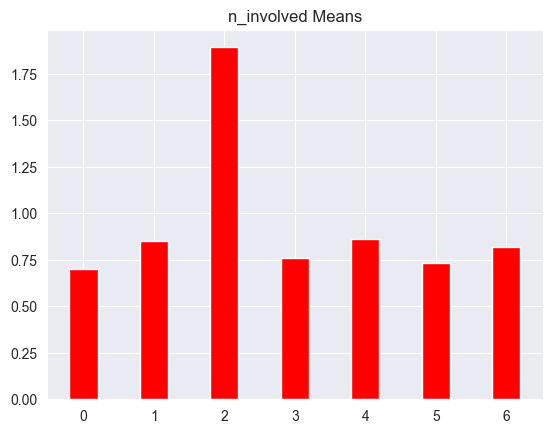

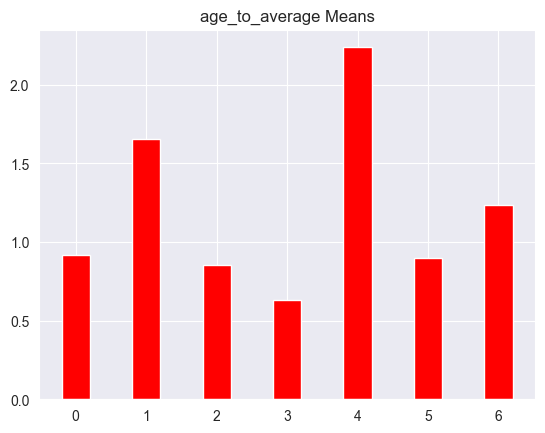

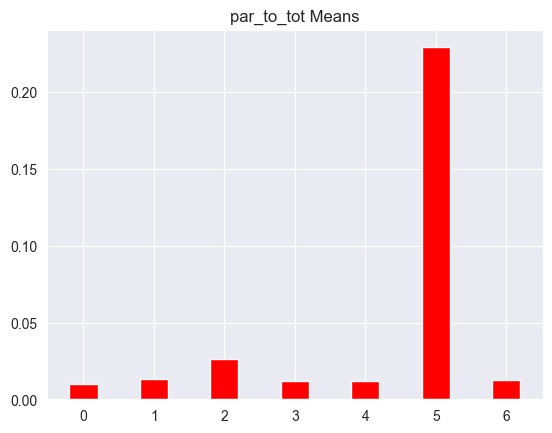

In [9]:
cols = df_cut.columns
for col in range(len(cols)-1):
    means = []
    for x in label:
        temp = df_cut[df_cut['Cluster'] == x]
        temp = temp.drop(columns=['Cluster'])
        means.append(temp.describe()[cols[col]][1])
    plt.bar(label, means, color ='red', 
            width = 0.4)
    plt.title(cols[col] + " Means")
    plt.show()   

- 0 = Low number of participants and around average age (80k) 
- 1 = Average number of participants above average age (higher than 6) (15k)
- 2 = Very High number of participants and involved that don't make up the bulk of the states total (14k)
- 3 = Average number of participants below average age (39k)
- 4 = Average number of participants with very high average age (5k)
- 5 = High number of participants that make up the bulk of the states total (1k)
- 6 = Average number of participants above average age (27k)

Perhaps we could merge 1 and 6

In [10]:
df_cut[df_cut['Cluster'] == 1].describe()

,n_participants,n_involved,age_to_average,par_to_tot,Cluster
count,15189.000000,15189.000000,15189.000000,15189.000000,15189.0
mean,1.693462,0.848838,1.657283,0.012953,1.0
std,0.867080,0.738753,0.140981,0.018201,0.0
min,1.000000,0.000000,1.445557,0.001143,1.0
25%,1.000000,0.000000,1.533714,0.004032,1.0
50%,2.000000,1.000000,1.638670,0.007246,1.0
75%,2.000000,1.000000,1.770791,0.014085,1.0
max,11.000000,9.000000,1.948406,0.222222,1.0


In [11]:
df_cut[df_cut['Cluster'] == 6].describe()

,n_participants,n_involved,age_to_average,par_to_tot,Cluster
count,27426.000000,27426.000000,27426.000000,27426.000000,27426.0
mean,1.720484,0.819551,1.238388,0.012626,6.0
std,0.843253,0.683654,0.103618,0.016233,0.0
min,1.000000,0.000000,1.063024,0.001143,6.0
25%,1.000000,0.000000,1.148161,0.004024,6.0
50%,2.000000,1.000000,1.225932,0.007299,6.0
75%,2.000000,1.000000,1.322406,0.013889,6.0
max,8.000000,5.000000,1.447591,0.166667,6.0


In [12]:
df_cut['Cluster'] = df_cut['Cluster'].replace(6, 1)
df_cut[df_cut['Cluster'] == 1].describe()

,n_participants,n_involved,age_to_average,par_to_tot,Cluster
count,42615.000000,42615.000000,42615.000000,42615.000000,42615.0
mean,1.710853,0.829989,1.387692,0.012743,1.0
std,0.851910,0.703918,0.232907,0.016961,0.0
min,1.000000,0.000000,1.063024,0.001143,1.0
25%,1.000000,0.000000,1.192254,0.004024,1.0
50%,2.000000,1.000000,1.337521,0.007299,1.0
75%,2.000000,1.000000,1.553047,0.013913,1.0
max,11.000000,9.000000,1.948406,0.222222,1.0


They differ only on age, they cover similar age groups, we decided to merge them!

cluster occurrences: [79730, 42615, 14441, 39970, 5573, 1325]


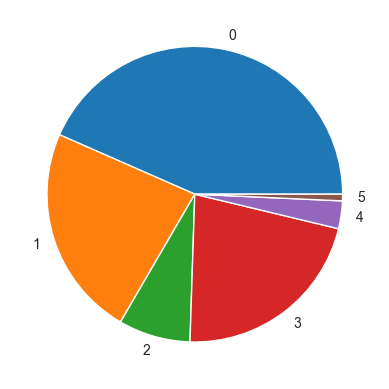

In [13]:
n_clusters = len(np.unique(df_cut['Cluster']))
label = range(n_clusters)
occ_list = []
for k in range(n_clusters):
    occ_list.append(np.count_nonzero(df_cut['Cluster'] == k))
print('cluster occurrences:', occ_list)
plt.pie(occ_list, labels=label, colors=sn.color_palette(n_colors=n_clusters))
plt.show()

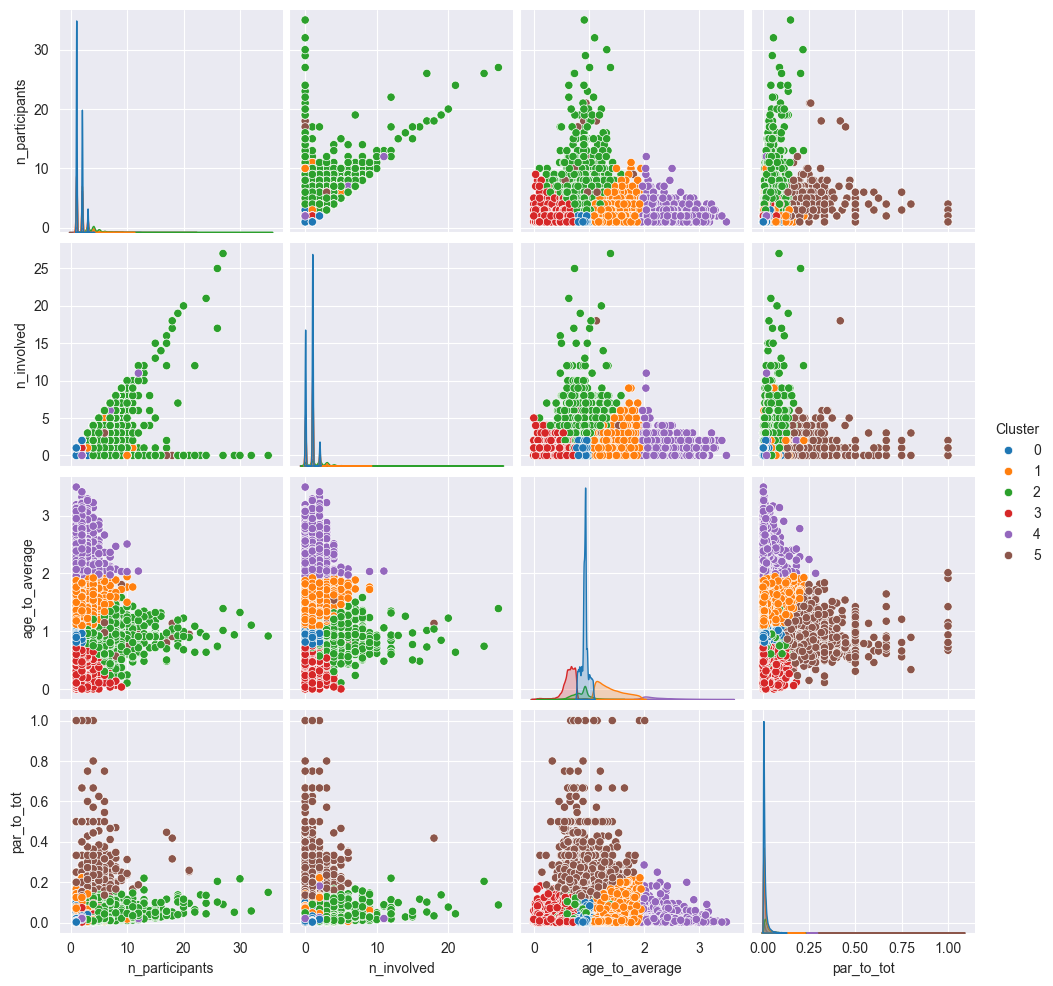

In [14]:
sn.pairplot(df_cut,hue='Cluster', palette=sn.color_palette(n_colors=n_clusters))
plt.show()

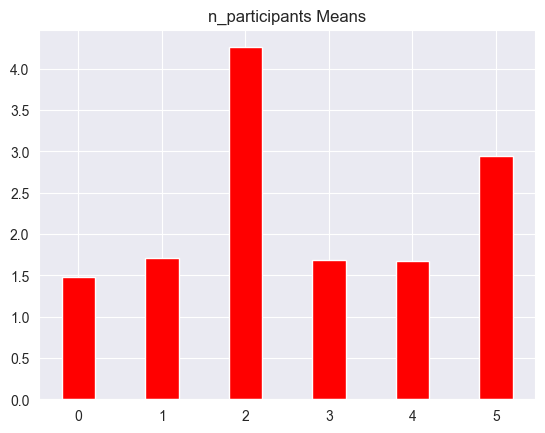

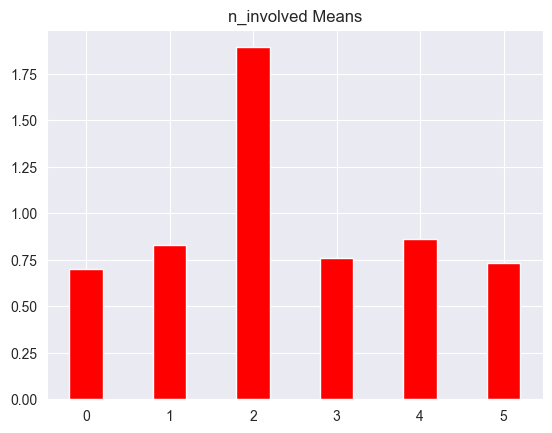

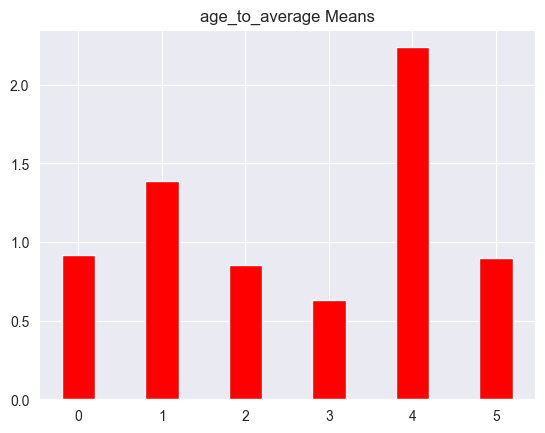

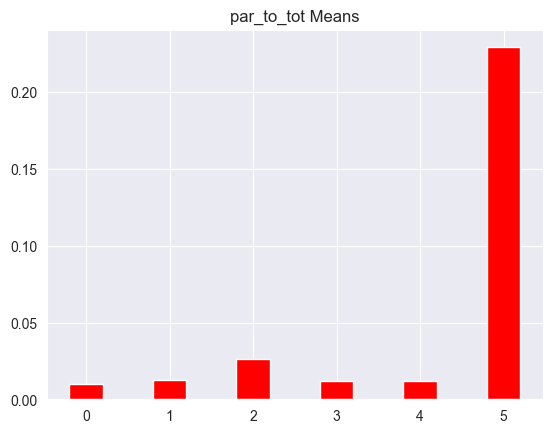

In [15]:
cols = df_cut.columns
for col in range(len(cols)-1):
    means = []
    for x in label:
        temp = df_cut[df_cut['Cluster'] == x]
        temp = temp.drop(columns=['Cluster'])
        means.append(temp.describe()[cols[col]][1])
    plt.bar(label, means, color ='red', 
            width = 0.4)
    plt.title(cols[col] + " Means")
    plt.show()   

- 0 = Low number of participants and around average age (80k) 
- 1 = Average number of participants above average age (15k)
- 2 = Very High number of participants and involved that don't make up the bulk of the states total (14k)
- 3 = Average number of participants below average age (39k)
- 4 = Average number of participants with very high average age (5k)
- 5 = High number of participants that make up the bulk of the states total (1k)

In [16]:
df['Cluster'] = df_cut['Cluster']
df.head()

,date,state,city_or_county,latitude,longitude,congressional_district,avg_age_participants,n_participants_adult,n_males,n_females,...,man_to_p,fem_to_p,arr_to_p,unh_to_p,inj_to_p,n_minors,teen_to_m,teen_to_f,par_to_tot,Cluster
0,2015-05-02,Indiana,Indianapolis,39.8322,-86.2492,7.0,19.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.009091,3
1,2017-04-03,Pennsylvania,Kane,41.6645,-78.7856,5.0,62.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003861,4
2,2016-11-05,Michigan,Detroit,42.4190,-83.0393,14.0,27.0,NaN,NaN,NaN,...,NaN,NaN,0.0,0.5,0.5,NaN,0.0,0.0,0.010638,0
3,2016-10-15,District of Columbia,Washington,38.9030,-76.9820,1.0,25.0,1.0,1.0,0.0,...,0.5,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.046512,0
4,2014-01-18,North Carolina,Wayne County,35.1847,-77.9527,13.0,65.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.004587,4


We plot the occurrence of each incident category in the clusters

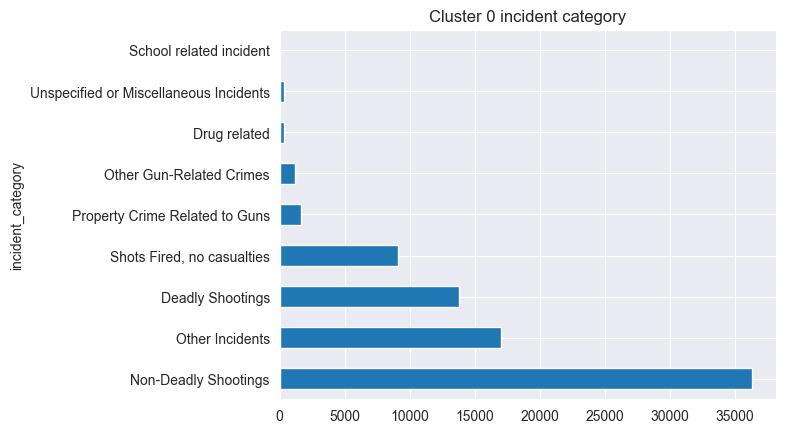

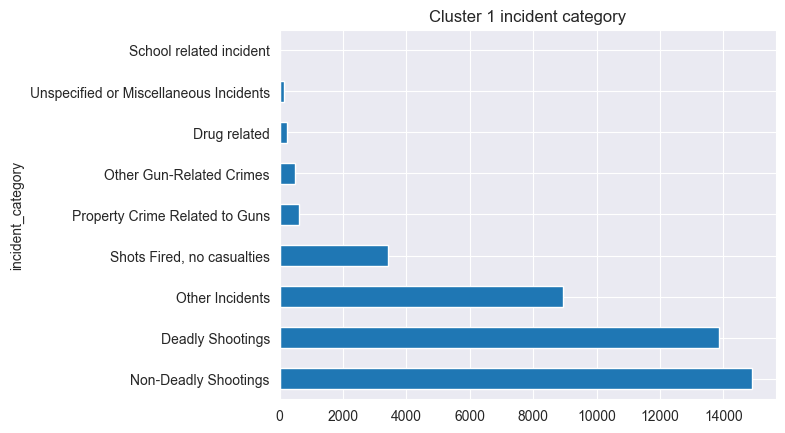

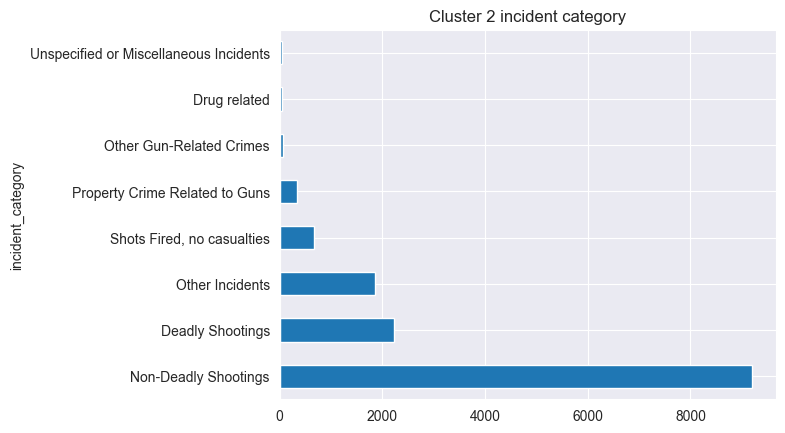

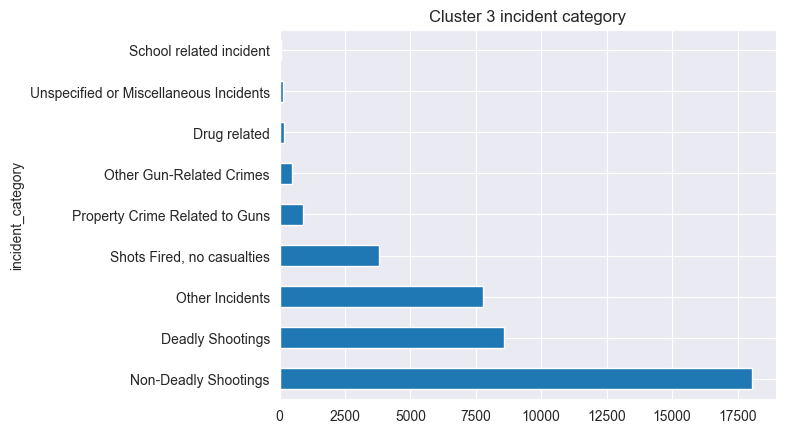

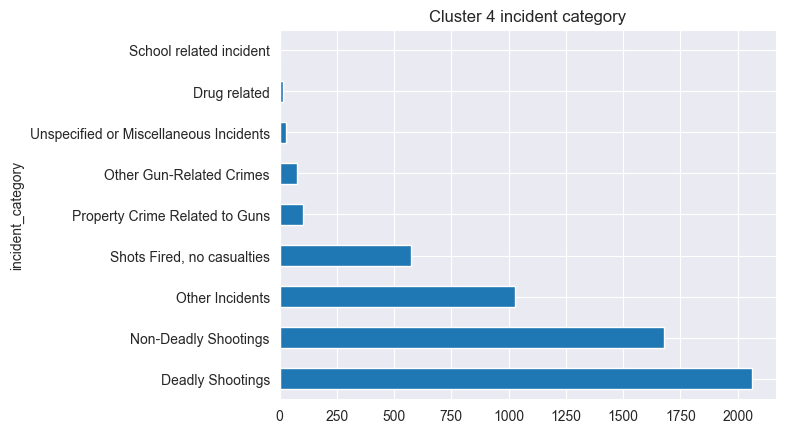

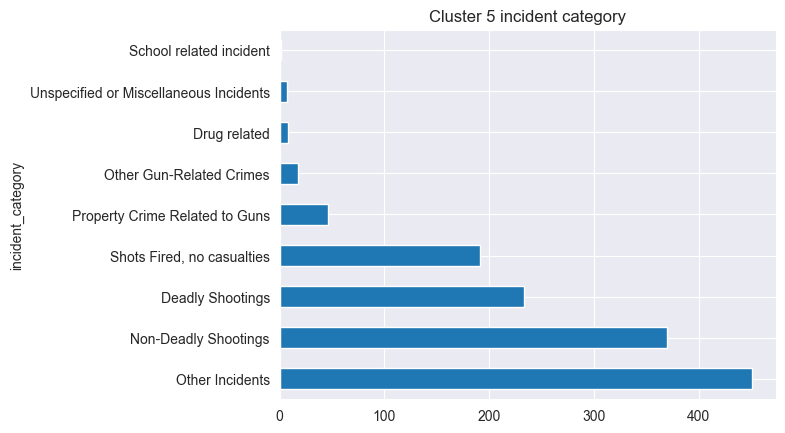

In [17]:
for k in range(n_clusters):  
    temp = df[df['Cluster'] == k]
    incident_type = temp['incident_category'].value_counts()
    incident_type.plot(kind='barh', linewidth=1)
    plt.title("Cluster " + str(k) + " incident category")
    plt.show()

We also plot the average age in each cluster

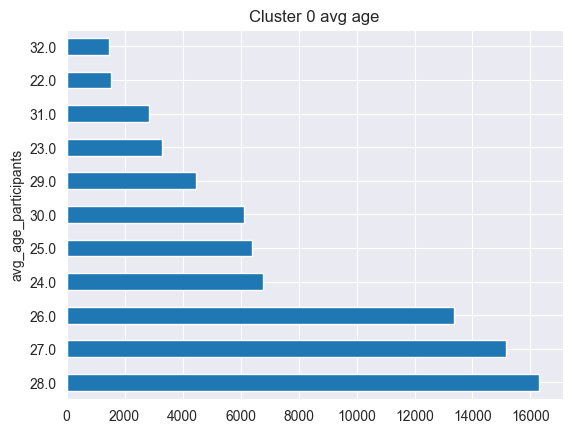

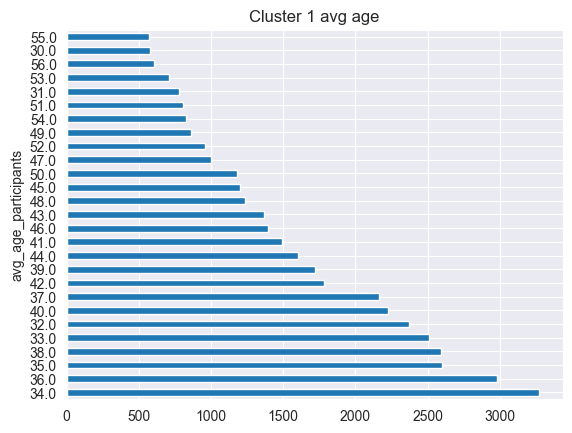

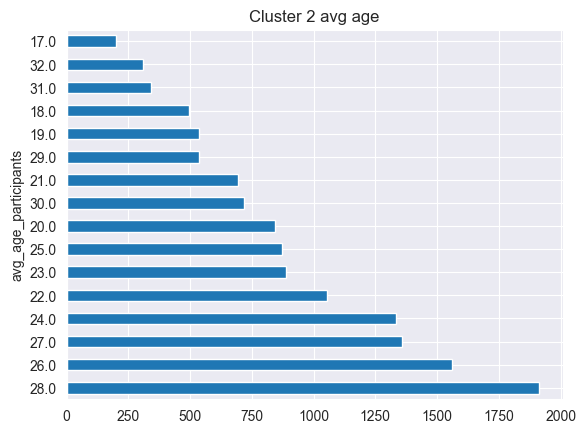

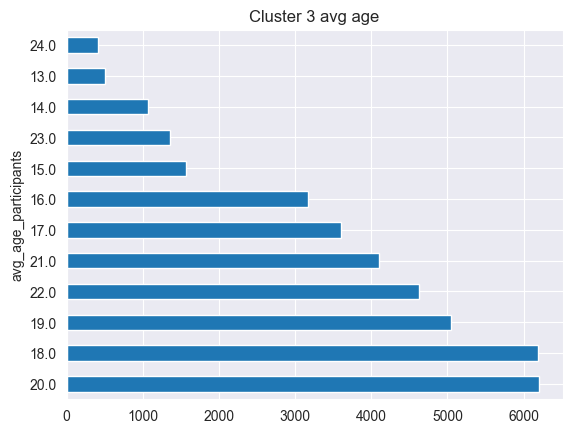

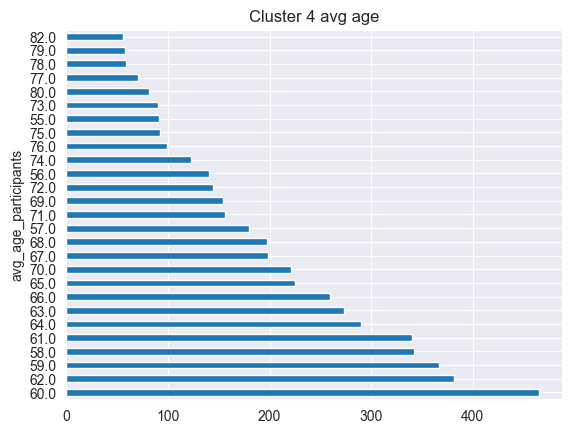

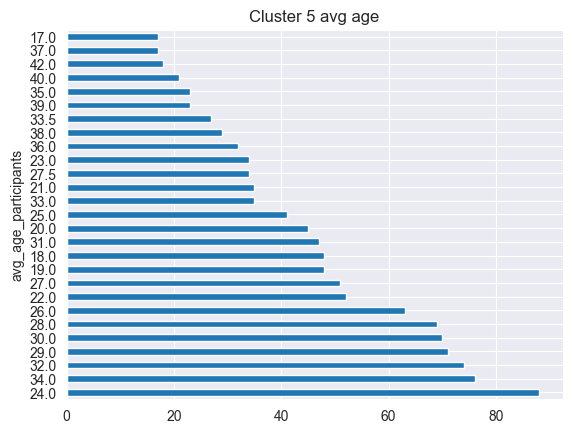

In [18]:
for k in range(n_clusters):  
    temp = df[df['Cluster'] == k]
    avg_age = temp['avg_age_participants'].value_counts()
    avg_age = avg_age[avg_age >= (len(temp)*0.01)]
    avg_age.plot(kind='barh', linewidth=1)
    plt.title("Cluster " + str(k) + " avg age")
    plt.show()

We also plot the average number of participants in each cluster

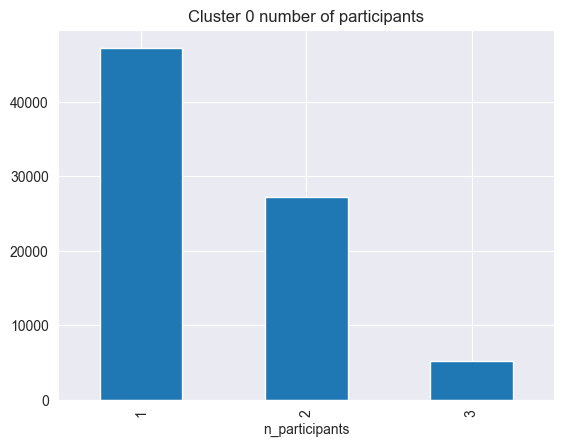

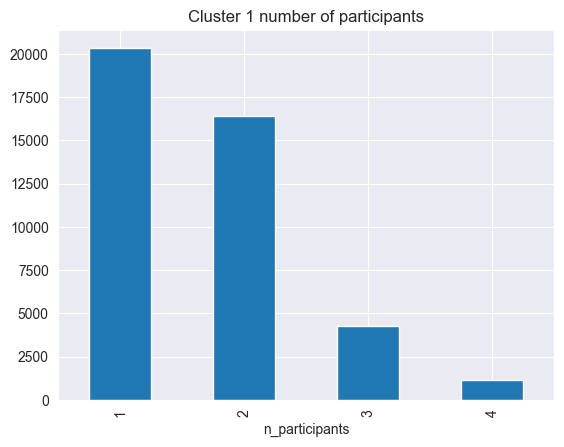

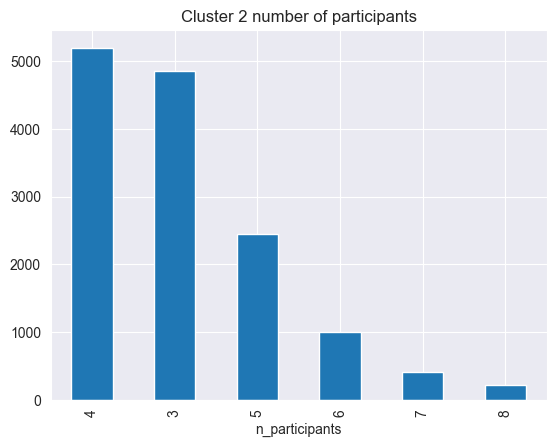

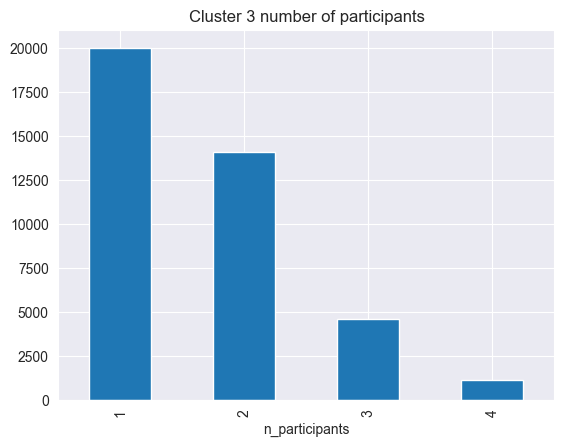

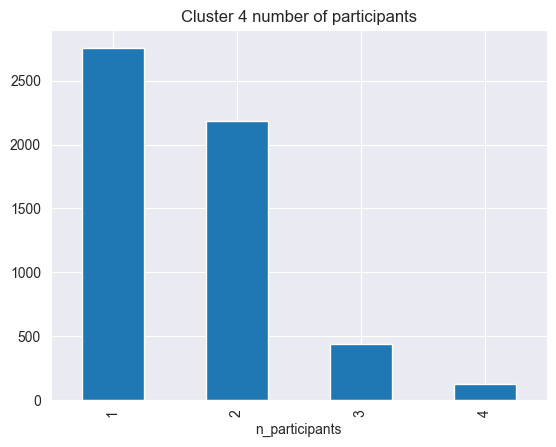

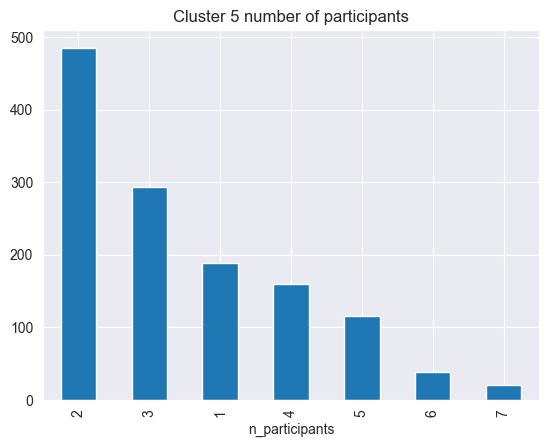

In [19]:
for k in range(n_clusters):  
    temp = df[df['Cluster'] == k]
    num_par = temp['n_participants'].value_counts()
    num_par = num_par[num_par >= (len(temp)*0.01)]
    num_par.plot(kind='bar', linewidth=1)
    plt.title("Cluster " + str(k) + " number of participants")
    plt.show()

We also plot the average number of involved participants in each cluster

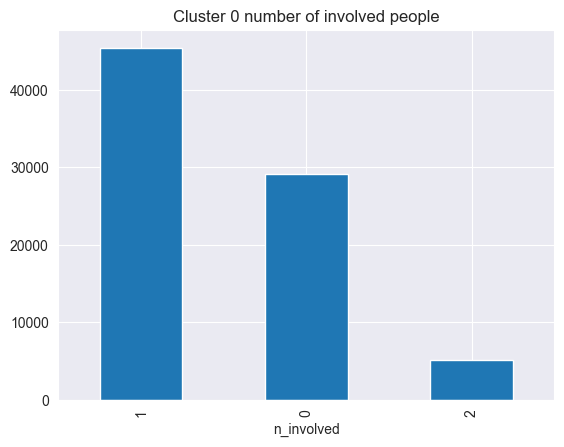

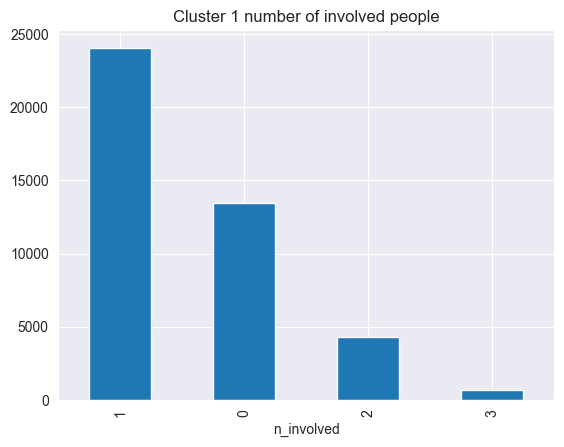

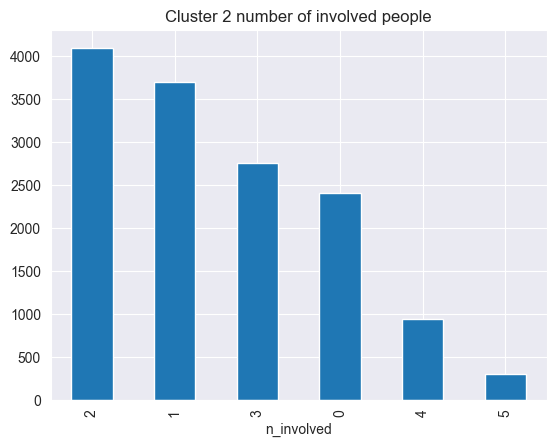

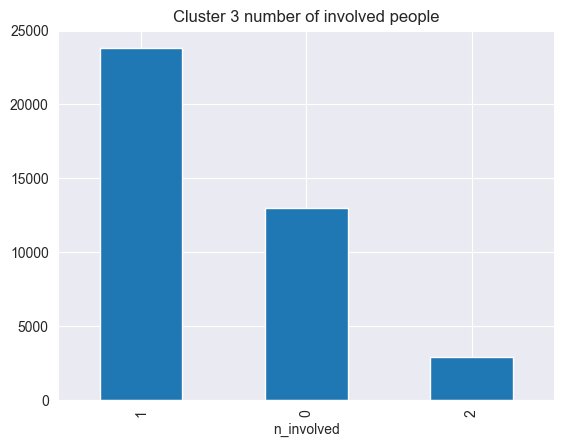

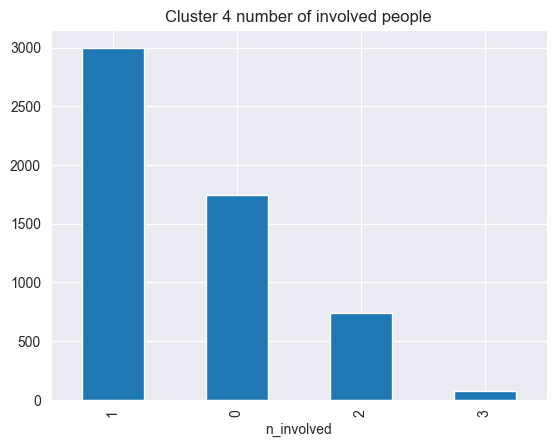

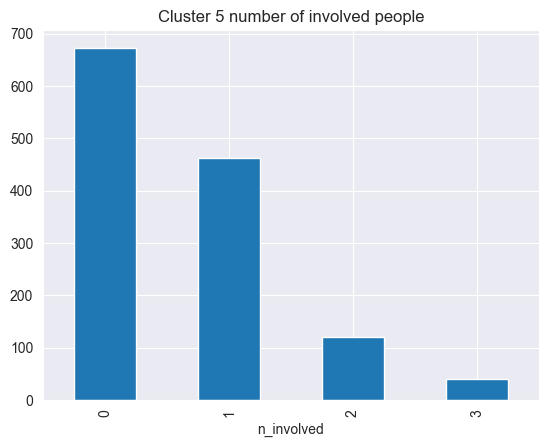

In [20]:
for k in range(n_clusters):  
    temp = df[df['Cluster'] == k]
    num_inv = temp['n_involved'].value_counts()
    num_inv = num_inv[num_inv >= (len(temp)*0.01)]
    num_inv.plot(kind='bar', linewidth=1)
    plt.title("Cluster " + str(k) + " number of involved people")
    plt.show()

We also plot the average number of minors in each cluster

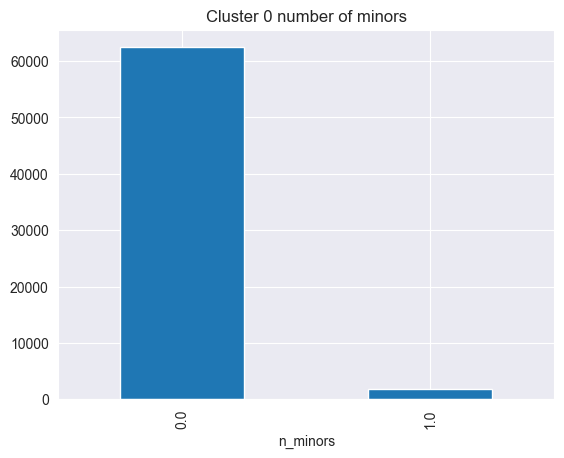

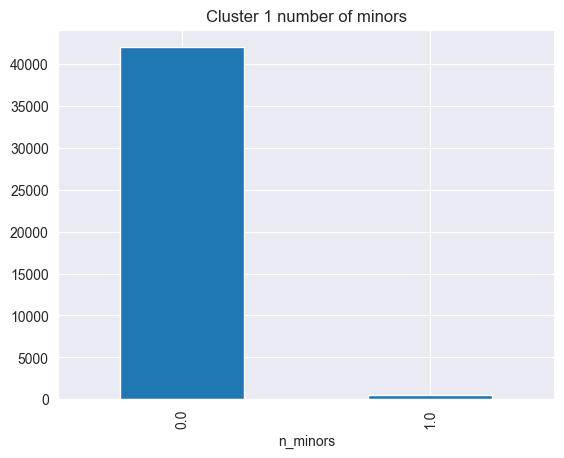

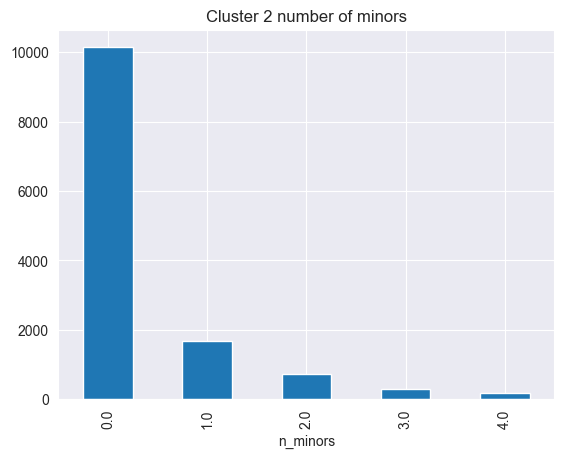

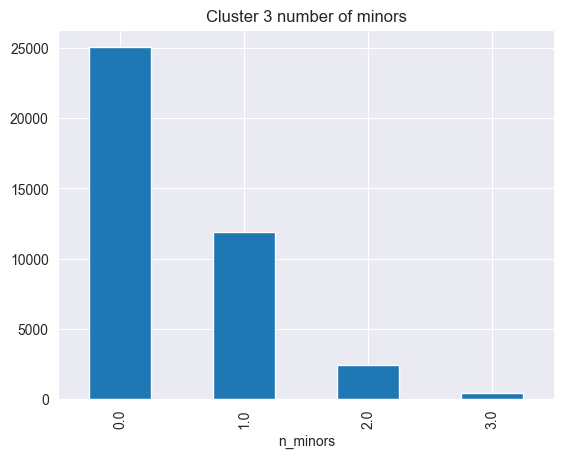

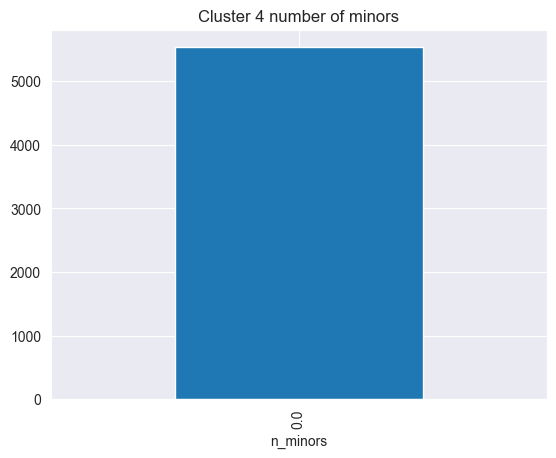

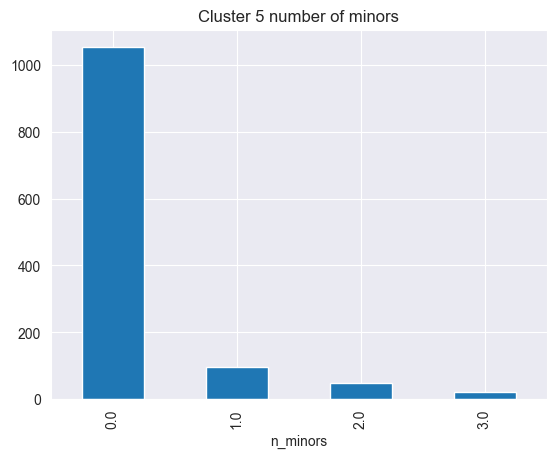

In [21]:
for k in range(n_clusters):  
    temp = df[df['Cluster'] == k]
    num_min = temp['n_minors'].value_counts()
    num_min = num_min[num_min >= (len(temp)*0.01)]
    num_min.plot(kind='bar', linewidth=1)
    plt.title("Cluster " + str(k) + " number of minors")
    plt.show()

Now, we try to show a connection between Cluster 3, the one with the most incidents involving minors, and school incidents

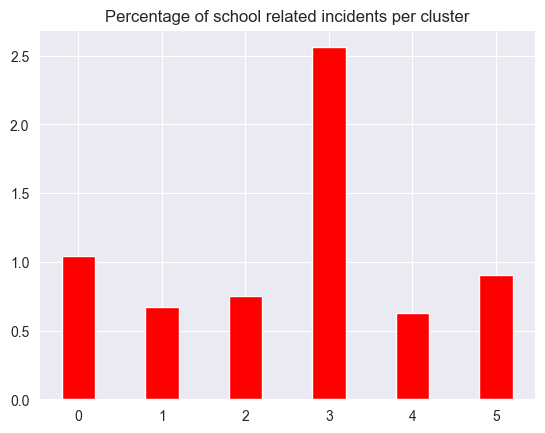

In [22]:
school_percentage = []
for k in range(n_clusters):  
    temp = df[df['Cluster'] == k]
    total_row = len(temp)
    temp = temp[(temp['incident_category'] == 'School related incident') | (temp['notes'].str.lower().str.contains('school'))]
    partial_row = len(temp)
    percentage = (partial_row/total_row)*100
    school_percentage.append(percentage)
plt.bar(label, school_percentage, color ='red', width = 0.4)
plt.title("Percentage of school related incidents per cluster")
plt.show()

At last, we try to show a connection between Cluster 5, the one with the lowest percentage of killed people per participant in an incident, and drug related offences.

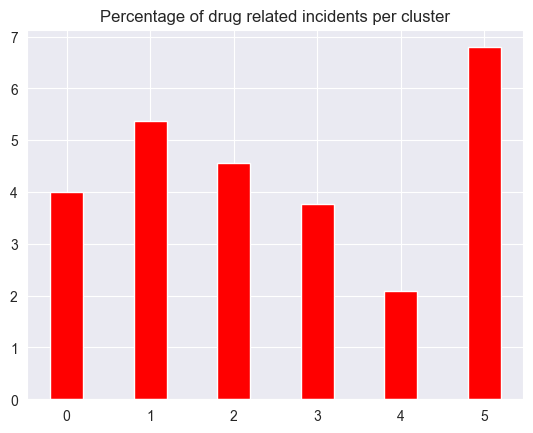

In [23]:
drug_percentage = []
for k in range(n_clusters):  
    temp = df[df['Cluster'] == k]
    total_row = len(temp)
    temp = temp[(temp['incident_category'] == 'Drug related') | (temp['notes'].str.lower().str.contains('drug'))]
    partial_row = len(temp)
    percentage = (partial_row/total_row)*100
    drug_percentage.append(percentage)
plt.bar(label, drug_percentage, color ='red', width = 0.4)
plt.title("Percentage of drug related incidents per cluster")
plt.show()

# Final Conclusions

Average incident = low number of participants and people involved (killed + injured)

- Cluster 0 = Average incidents involving mostly young adults
- Cluster 1 = Average incidents involving mostly middle-aged adults
- Cluster 2 = Incidents with a lot of participants and high number of people involved (high number of involved => mass shootings)
- Cluster 3 = Average incidents involving mostly minors and very young adults
- Cluster 4 = Average incidents involving mostly elderly
- Cluster 5 = Incidents with a lot of participants and low number of people involved (Almost null number of minors => probably drug related)